# Notebook to create 2D initial conditions to Mandyoc

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy import interpolate

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from functions.mandyocIO import make_coordinates, make_interface, merge_interfaces, save_interfaces, make_grid, save_temperature, diffuse_field

np.set_printoptions(threshold=5)

Create a directory to save the input files:

In [2]:
run_dir = os.path.join("input")
if not os.path.isdir(run_dir):
    os.makedirs(run_dir)
# clean input folder to romeve unwanted files
!rm {run_dir}/input_temperature_0.txt {run_dir}/input_velocity_0.txt {run_dir}/interfaces.txt {run_dir}/param.txt
# mm/yr converter
mm_per_year = 1.0E-3 / (365 * 24 * 60 * 60)

rm: cannot remove 'input/input_velocity_0.txt': No such file or directory


In [3]:
# Air layer [m]
h_air = -40.0e3

# Use lubricant contact oceanic lithosphere
lubricant_contact = False

# Use lubricant layer
lubricant_layer = True
lubricant_layer_horizontal_length = 50.0e3

# Use plate model
plate_model = False
N = 10 # plate model iteration number
u = 50 * mm_per_year # seafloor spreading velocity

# Diffuse temperature field
diffuse_temperature = False

# Set if velocity will be imposed on the sides
velocity_borders = False
u0 = 50.0 * mm_per_year # maximum velocity on the left side
clearance = 15.0E3 # velocity is also imposed <clearance> meters above and below the lithosphere

## Initial Setup

Define and create the mesh geometry:

In [4]:
x_min, x_max, z_min, z_max = 0.0e3, 5000.0e3, -1000.0e3 + h_air, 0.0e3  # m
# x_min, x_max, z_min, z_max = 0.0e3, 3500.0e3, -960.0e3 + h_air, 0.0e3  # m -> cenário Claudio
region = (x_min, x_max, z_min, z_max)
shape = (801, 161)
# shape = (351, 101) # -> cenário Claudio

# Create the coordinates for the region
coordinates = make_coordinates(region, shape)
print(coordinates)
dshape = (float(coordinates["x"][1]-coordinates["x"][0]), float(coordinates["z"][1]-coordinates["z"][0]))

boundaries = {}
units = {}

Coordinates:
  * x        (x) float64 0.0 6.25e+03 1.25e+04 ... 4.988e+06 4.994e+06 5e+06
  * z        (z) float64 -1.04e+06 -1.034e+06 -1.027e+06 ... -6.5e+03 0.0


## General and auxiliary parameters

In [5]:
# General physical parameters
temp_LAB = 1300.0  # °
temp_air = 0.0 # °
heat_capacity = 1250  # Cp m2/Ks2 
alpha = 3.28E-5  # thermal expansion coefficient 1/K 
g = 9.8  # gravity m/s2
temp_0 = 1262.0  # °
particles_per_element = 81
kappa = 1.0e-6

## Interface geometric properties

In [6]:
# Edge clearance, lateral distance from the lithosphere and the sides of the model [m]
if (velocity_borders):
    edge_clearance = 0.0
else:
    edge_clearance = 200.0e3 #200.0e3

# Lower boundary of the astenosphere [m]
astenosphere_depth = -660e3  

# Non-subduction oceanic plate [m]
oceanic_lab_depth = -80e3
oceanic_crust_depth = -10e3 # -15e3

if (velocity_borders) or (plate_model):
    oceanic_thin_length = 0.0
else:
    oceanic_thin_length = 200e3

# Subducting slab portion [m]
subducting_slab_slope = 29 # 29°
subducting_slab_slope_rad = subducting_slab_slope * np.pi / 180.0 
subducting_slab_length = 200e3 # length of subducted slab

# top surface
subducting_slab_top_x_max = x_max / 2.0 #5700e3 / 2.0 # 5700e3  
# subducting_slab_top_x_max = 1500e3 # -> Claudio
subducting_slab_top_x_min = subducting_slab_top_x_max - np.cos(subducting_slab_slope_rad) * subducting_slab_length  # x position where the slab begins to subduct 
subducting_slab_top_z_min = - subducting_slab_length * np.sin(subducting_slab_slope_rad)    # Maximum depth reached by the slab (~ 100 km below the surface)  

# bot surface
subducting_slab_bot_x_max = subducting_slab_top_x_max - (- oceanic_lab_depth * np.sin(subducting_slab_slope_rad))
subducting_slab_bot_z_min = subducting_slab_top_z_min - (- oceanic_lab_depth * np.cos(subducting_slab_slope_rad))
subducting_slab_bot_x_min = subducting_slab_bot_x_max - (- (subducting_slab_bot_z_min - oceanic_lab_depth) / np.tan(subducting_slab_slope_rad))

# crust surface
subducting_crust_bot_x_max = subducting_slab_top_x_max - (- oceanic_crust_depth * np.sin(subducting_slab_slope_rad))
subducting_crust_bot_z_min = subducting_slab_top_z_min - (- oceanic_crust_depth * np.cos(subducting_slab_slope_rad))
subducting_crust_bot_x_min = subducting_crust_bot_x_max - (- (subducting_crust_bot_z_min - oceanic_crust_depth) / np.tan(subducting_slab_slope_rad))

# Continental arc region [m]
continental_arc_length = 1300e3 
continental_arc_depth = -60e3  

# Non-arc continental (cratonic) region [m]
continental_lab_depth = -150e3  
continental_crust_depth = -30e3
if (velocity_borders):
    craton_thin_length = 0.0
else:
    craton_thin_length = 800.0e3 # 1600e3

# Lubricant layers
lubricant_layer_slope_rad = subducting_slab_slope_rad

# lubricant layer top
upper_lubricant_layer_x_min = subducting_slab_top_x_min + lubricant_layer_horizontal_length
upper_lubricant_layer_x_max = upper_lubricant_layer_x_min + (- continental_arc_depth / np.tan(lubricant_layer_slope_rad))
upper_lubricant_layer_z_min = continental_arc_depth

# lubrincat layer bot
lower_lubricant_layer_x_min = subducting_slab_top_x_min + (- continental_crust_depth / np.tan(lubricant_layer_slope_rad))
lower_lubricant_layer_x_max = lower_lubricant_layer_x_min + lubricant_layer_horizontal_length
lower_lubricant_layer_z_min = continental_crust_depth

# Craton transition
transition_x_min = subducting_slab_top_x_min + continental_arc_length 
transition_xlength = 400e3
transition_x_max = transition_x_min + transition_xlength
a = (continental_lab_depth - continental_arc_depth) / transition_xlength
b = continental_arc_depth - a * transition_x_min
transition_xmidle = (subducting_slab_top_z_min - b) / a

In [7]:
if (velocity_borders == False):
    z_ocean_lab = z_max
    z_ocean_crust = z_max
    z_continent_lab = z_max
    z_continent_crust = z_max
if (velocity_borders == True):
    z_ocean_lab = oceanic_lab_depth
    z_ocean_crust = oceanic_crust_depth
    z_continent_lab = continental_lab_depth
    z_continent_crust = continental_crust_depth

## Plate model

The oceanic lithosphere thickness $a_L$ can be estimated with

$$
a_{L} = 2.32 (\kappa t)^{1/2}= 2.32 \bigg(\frac{\kappa x}{u}\bigg)^{1/2}
$$

where $\kappa$ is the oceanic lithosphere coefficient of thermal diffusion, $t$ is the oceanic lithosphere age, and $u$ is the seafloor spreading velocity.

The oceanic lithosphere temperature $T$ can be calculated with

$$
T = T_{0} + (T_{1}-T_{0}) \bigg[ \frac{z}{a_{L}} + \frac{2}{\pi} \sum_{n=1}^{\infty} \frac{1}{n} \exp{\bigg(-\frac{\kappa n^2 \pi^2 t}{a_{L}^2} \bigg)} \sin{\bigg( \frac{n \pi z}{a_{L}} \bigg)} \bigg]
= T_{0} + (T_{1}-T_{0}) \bigg[ \frac{z}{a_{L}} + \frac{2}{\pi} \sum_{n=1}^{\infty} \frac{1}{n} \exp{\bigg(-\frac{\kappa n^2 \pi^2 x}{u a_{L}^2} \bigg)} \sin{\bigg( \frac{n \pi z}{a_{L}} \bigg)} \bigg]
$$

In [8]:
def plate_model_temperature(T0, T1, x, z, aL, u, N, kappa):
       
    nx, nz = np.size(x), np.size(z)
    T = np.zeros((nx, nz))
    aL[0] += 1.0E-100 # avoid division by zero
    
    for i in range(nx):
        csum = 0
        for n in range(1, N):
            aux1 = np.sin(n*np.pi*z/aL[i])
            aux2 = np.exp(-(n**2)*(np.pi**2)*kappa*x[i]/(u*(aL[i]**2)))
            csum += (aux1*aux2/n)
        aux = (z / aL[i]) + ((2.0 / np.pi) * csum)
        T[i] = T0 + ((T1 - T0) * (aux))
    
    cond = (T > T1)
    T[cond] = T1
    
    return T

if (plate_model):
    # z domain
    plate_z = np.array(coordinates["z"])
    cond = (plate_z <= 0) & ((plate_z >= oceanic_lab_depth))
    plate_z = abs(plate_z[cond])

    # complete x domain
    plate_x = np.array(coordinates["x"])

    # lab thickness
    aL = 2.32 * (kappa * plate_x / u)**(0.5)
    xL = np.copy(plate_x)
    for i in range(np.size(aL)):
        if aL[i] > abs(oceanic_lab_depth):
            aL[i] = abs(oceanic_lab_depth)

    # filtered x domain
    cond = (aL < abs(oceanic_lab_depth))
    plate_x = plate_x[:np.sum(cond)+1] # pick the (n+1) values of x that satisfie the condition 

    # plate model
    plate_T = plate_model_temperature(temp_air, temp_LAB, plate_x, plate_z, aL, u, N, kappa)

    # correction to plate_x and plate_z
    corrected_x = plate_x + edge_clearance
    corrected_z = h_air - plate_z
    extent = [corrected_x[0]/ 1.0e3, corrected_x[-1]/ 1.0e3, corrected_z[0]/ 1.0e3, corrected_z[-1]/ 1.0e3] 

    # plot figure
    plt.figure(figsize=(20,7))
    plt.title("Temperature plate model for the oceanic lithosphere")
    plt.imshow(plate_T[:,::-1].T, extent=extent, aspect='auto')
    plt.xlabel("Depth [km]")
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    plt.ylabel("Length [km]")
    plt.colorbar(orientation="horizontal", label=r"Temperature [$^{\circ}$C]")
    plt.plot((xL+edge_clearance)/1.0e3, (h_air-aL)/1.0e3, color="red")

**Lower mantle top**

In [9]:
lower_mantle = make_interface( 
    coordinates,
    astenosphere_depth
)

lower_mantle.attrs = {"compositional_factor":1.0,
                      "density":3378.0,
                      "radiogenic_heat":0.0,
                      "pre_exponential_scale_factor":1.393e-14,
                      "power_law_exponent":3.0,
                      "activation_energy":429.0e3,
                      "activation_volume":15.0e-6}

boundaries["lower_mantle_top"] = lower_mantle
units["lower_mantle"] = lower_mantle

**Astenosphere 1 top**

In [10]:
astenosphere_1_vertices = [
    [x_min, z_ocean_lab],
    [x_min + edge_clearance, z_ocean_lab],
    [x_min + edge_clearance + oceanic_thin_length, oceanic_lab_depth],
    [subducting_slab_bot_x_min, oceanic_lab_depth],
    [subducting_slab_bot_x_max, subducting_slab_bot_z_min],
    [subducting_slab_top_x_max, subducting_slab_top_z_min],
    [transition_xmidle, subducting_slab_top_z_min],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

astenosphere_1 = make_interface(
    coordinates,
    astenosphere_1_vertices
)

if (plate_model):
    beg = np.where(astenosphere_1["x"].values >= edge_clearance)[0][0]
    end = beg + np.size(plate_x)
    astenosphere_1.values[beg:end] = -aL[:(end-beg)]

astenosphere_1.attrs = {"compositional_factor":1.0,
                        "density":3378.0,
                        "radiogenic_heat":0.0,
                        "pre_exponential_scale_factor":1.393e-14,
                        "power_law_exponent":3.0,
                        "activation_energy":429.0e3,
                        "activation_volume":15.0e-6}

boundaries["astenosphere_1_top"] = astenosphere_1
units["astenosphere_1"] = astenosphere_1

**Oceanic lithospheric mantle top**

In [11]:
oceanic_lithospheric_mantle_vertices = [
    [x_min, z_ocean_crust],
    [x_min + edge_clearance, z_ocean_crust],
    [x_min + edge_clearance + oceanic_thin_length, oceanic_crust_depth],
    [subducting_crust_bot_x_min, oceanic_crust_depth],
    [subducting_crust_bot_x_max, subducting_crust_bot_z_min],
    [subducting_slab_top_x_max, subducting_slab_top_z_min],
    [transition_xmidle, subducting_slab_top_z_min],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

oceanic_lithospheric_mantle = make_interface(
    coordinates,
    oceanic_lithospheric_mantle_vertices
)

if (plate_model):
    beg = np.where(oceanic_lithospheric_mantle["x"].values >= edge_clearance)[0][0]
    end = beg + np.size(plate_x)
    scale = oceanic_crust_depth / oceanic_lab_depth
    oceanic_lithospheric_mantle.values[beg:end] = - scale * aL[:(end-beg)]

oceanic_lithospheric_mantle.attrs = {"compositional_factor":1.0,
                                     "density":3400.0,
                                     "radiogenic_heat":9.0e-12,
                                     "pre_exponential_scale_factor":2.4168e-15,
                                     "power_law_exponent":3.5,
                                     "activation_energy":540.0e3,
                                     "activation_volume":25.0e-6}

boundaries["oceanic_lithospheric_mantle_top"] = oceanic_lithospheric_mantle
units["oceanic_lithospheric_mantle"] = oceanic_lithospheric_mantle

**Subducted oceanic crust portion**

In [12]:
oceanic_crust_density = 3400.0

oceanic_subducted_crust_vertices = [
    [x_min, z_ocean_crust],
    [x_min + edge_clearance, z_ocean_crust],
    [x_min + edge_clearance + oceanic_thin_length, oceanic_crust_depth],
    [subducting_crust_bot_x_min, oceanic_crust_depth], # aqui?
    [subducting_slab_top_x_min, z_max],
    [subducting_slab_top_x_max, subducting_slab_top_z_min],
    [transition_xmidle, subducting_slab_top_z_min],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

oceanic_subducted_crust = make_interface(
    coordinates,
    oceanic_subducted_crust_vertices
)

oceanic_subducted_crust.attrs = {"compositional_factor":0.01,
                       "density":oceanic_crust_density,
                       "radiogenic_heat":0.8e-6/oceanic_crust_density,
                       "pre_exponential_scale_factor":8.574e-28,
                       "power_law_exponent":4.0,
                       "activation_energy":222.0e3,
                       "activation_volume":0.0}

if (lubricant_contact):
    boundaries["oceanic_subducted_crust_top"] = oceanic_subducted_crust
    units["oceanic_subducted_crust"] = oceanic_subducted_crust

**Oceanic crust top**

In [13]:
oceanic_crust_vertices = [
    [x_min, z_max],
    [x_min + edge_clearance, z_max],
    [x_min + edge_clearance + oceanic_thin_length, z_max],
    [subducting_slab_top_x_min, z_max],
    [subducting_slab_top_x_max, subducting_slab_top_z_min],
    [transition_xmidle, subducting_slab_top_z_min],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

oceanic_crust = make_interface(
    coordinates,
    oceanic_crust_vertices
)

oceanic_crust.attrs = {"compositional_factor":1.0,
                       "density":oceanic_crust_density,
                       "radiogenic_heat":0.8e-6/oceanic_crust_density,
                       "pre_exponential_scale_factor":8.574e-28,
                       "power_law_exponent":4.0,
                       "activation_energy":222.0e3,
                       "activation_volume":0.0}

boundaries["oceanic_crust_top"] = oceanic_crust
units["oceanic_crust"] = oceanic_crust

**Astenosphere 2 top**

In [14]:
subducting_slab_xmidle = subducting_slab_top_x_min + continental_arc_depth / np.tan(subducting_slab_slope_rad)

astenosphere_2_vertices = [
    [x_min, continental_arc_depth],
    [subducting_slab_top_x_min, continental_arc_depth],
    [transition_x_min, continental_arc_depth],
    [transition_x_max, continental_lab_depth],
    [x_max, continental_lab_depth],
]

astenosphere_2 = make_interface(
    coordinates,
    astenosphere_2_vertices
)

astenosphere_2.attrs = {"compositional_factor":1.0,
                        "density":3378,
                        "radiogenic_heat":0.0,
                        "pre_exponential_scale_factor":1.393E-14,
                        "power_law_exponent":3.0,
                        "activation_energy":429.0e3,
                        "activation_volume":15.0e-6}

boundaries["astenosphere_2_top"] = astenosphere_2
units["astenosphere_2"] = astenosphere_2

**Lubricant layer bot**

In [15]:
lower_lubricant_layer_vertices = [
    [x_min, z_max],
    [x_min + edge_clearance, z_max],
    [x_min + edge_clearance + oceanic_thin_length, z_max],
    [subducting_slab_top_x_min, z_max],
    [lower_lubricant_layer_x_min, continental_crust_depth],
    [lower_lubricant_layer_x_max, continental_crust_depth],
    [upper_lubricant_layer_x_max, upper_lubricant_layer_z_min],
    [transition_x_min, continental_arc_depth],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

lower_lubricant_layer = make_interface(
    coordinates,
    lower_lubricant_layer_vertices
)

lower_lubricant_layer.attrs = {"compositional_factor":1.0,
                               "density":3354.0,
                               "radiogenic_heat":9.0e-12,
                               "pre_exponential_scale_factor":2.4168E-15,
                               "power_law_exponent":3.5,
                               "activation_energy":540.0e3,
                               "activation_volume":25.0e-6}

if (lubricant_layer):
    boundaries["lower_lubricant_layer_top"] = lower_lubricant_layer
    units["lower_lubricant_layer"] = lower_lubricant_layer

**Lubricant layer top**

In [16]:
continental_crust_density = 2750.0

upper_lubricant_layer_vertices = [
    [x_min, z_max],
    [x_min + edge_clearance, z_max],
    [x_min + edge_clearance + oceanic_thin_length, z_max],
    [subducting_slab_top_x_min, z_max],
    [upper_lubricant_layer_x_min, z_max],
    [upper_lubricant_layer_x_max, upper_lubricant_layer_z_min],
    [transition_x_min, continental_arc_depth],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab],
]

upper_lubricant_layer = make_interface(
    coordinates,
    upper_lubricant_layer_vertices
)

upper_lubricant_layer.attrs = {"compositional_factor":1.0,
                               "density":continental_crust_density,
                               "radiogenic_heat":2.5E-6/continental_crust_density,
                               "pre_exponential_scale_factor":8.574e-28,
                               "power_law_exponent":4.0,
                               "activation_energy":222.0e3,
                               "activation_volume":0.0e-6}

if (lubricant_layer):
    boundaries["upper_lubricant_layer_top"] = upper_lubricant_layer
    units["upper_lubricant_layer"] = upper_lubricant_layer

**Continental lithospheric mantle top**

In [17]:
continental_lithospheric_mantle_vertices = [
    [x_min, continental_crust_depth],
    [transition_x_max, continental_crust_depth],
    [x_max - craton_thin_length, continental_crust_depth],
    [x_max - edge_clearance, z_continent_crust],
    [x_max, z_continent_crust],
]

continental_lithospheric_mantle = make_interface(
    coordinates,
    continental_lithospheric_mantle_vertices
)

continental_lithospheric_mantle.attrs = {"compositional_factor":1.0,
                                         "density":3354.0,
                                         "radiogenic_heat":9.0e-12,
                                         "pre_exponential_scale_factor":2.4168E-15,
                                         "power_law_exponent":3.5,
                                         "activation_energy":540.0e3,
                                         "activation_volume":25.0e-6}

boundaries["continental_lithospheric_mantle_top"] = continental_lithospheric_mantle
units["continental_lithospheric_mantle"] = continental_lithospheric_mantle

**Continental crust top** 

In [18]:
continental_crust = make_interface(
    coordinates,
    values=0.0
)

continental_crust.attrs = {"compositional_factor":1.0,
                           "density":continental_crust_density,
                           "radiogenic_heat":2.5E-6/continental_crust_density,
                           "pre_exponential_scale_factor":8.574e-28,
                           "power_law_exponent":4.0,
                           "activation_energy":222.0e3,
                           "activation_volume":0.0}

boundaries["continental_crust_top"] = continental_crust
units["continental_crust"] = continental_crust

**Air layer**

In [19]:
air_layer = make_interface(
    coordinates,
    values=0.0
)

air_layer.attrs = {"compositional_factor":1.0,
                   "density":1.0,
                   "radiogenic_heat":0.0,
                   "pre_exponential_scale_factor":1.0e-18,
                   "power_law_exponent":1.0,
                   "activation_energy":0.0,
                   "activation_volume":0.0}

units["air_layer"] = air_layer    

if (h_air==0):
    del boundaries[list(boundaries.keys())[-1]]
    del units[list(units.keys())[-1]]

In [20]:
lower_mantle.values += h_air
print(80*'=', '\nlower_mantle')
print(80*'=', '\n', lower_mantle)
astenosphere_1.values += h_air
print(80*'=', '\nastenosphere_1')
print(80*'=', '\n', astenosphere_1)
oceanic_lithospheric_mantle.values += h_air
print(80*'=', '\noceanic_lithospheric_mantle')
print(80*'=', '\n', oceanic_lithospheric_mantle)
if (lubricant_contact):
    oceanic_subducted_crust.values += h_air
    print(80*'=', '\noceanic_subducted_crust')
    print(80*'=', '\n', oceanic_subducted_crust)
oceanic_crust.values += h_air
print(80*'=', '\noceanic_crust')
print(80*'=', '\n', oceanic_crust)
astenosphere_2.values += h_air
print(80*'=', '\nastenosphere_2')
print(80*'=', '\n', astenosphere_2)
if (lubricant_layer):
    lower_lubricant_layer.values += h_air
    print(80*'=', '\nlower_lubricant_layer')
    print(80*'=', '\n', lower_lubricant_layer)
    upper_lubricant_layer.values += h_air
    print(80*'=', '\nupper_lubricant_layer')
    print(80*'=', '\n', upper_lubricant_layer)
continental_lithospheric_mantle.values += h_air
print(80*'=', '\ncontinental_lithospheric_mantle')
print(80*'=', '\n', continental_lithospheric_mantle)
continental_crust.values += h_air
print(80*'=', '\ncontinental_crust')
print(80*'=', '\n', continental_crust)
if (h_air<0):
    print(80*'=', '\nair_layer')
    print(80*'=', '\n', air_layer)

lower_mantle
 <xarray.DataArray (x: 801)>
array([-700000., -700000., -700000., ..., -700000., -700000., -700000.])
Coordinates:
  * x        (x) float64 0.0 6.25e+03 1.25e+04 ... 4.988e+06 4.994e+06 5e+06
Attributes:
    compositional_factor:          1.0
    density:                       3378.0
    radiogenic_heat:               0.0
    pre_exponential_scale_factor:  1.393e-14
    power_law_exponent:            3.0
    activation_energy:             429000.0
    activation_volume:             1.5e-05
astenosphere_1
 <xarray.DataArray (x: 801)>
array([-40000., -40000., -40000., ..., -40000., -40000., -40000.])
Coordinates:
  * x        (x) float64 0.0 6.25e+03 1.25e+04 ... 4.988e+06 4.994e+06 5e+06
Attributes:
    compositional_factor:          1.0
    density:                       3378.0
    radiogenic_heat:               0.0
    pre_exponential_scale_factor:  1.393e-14
    power_law_exponent:            3.0
    activation_energy:             429000.0
    activation_volume:         

**Correct interfaces depths and merge them into an xr.Dataset**

In [21]:
boundary_keys = list(boundaries.keys())

for i in range(1, len(boundaries)):
    boundaries[boundary_keys[i]].values = xr.where(
        boundaries[boundary_keys[i]].values <= boundaries[boundary_keys[i-1]].values,
        boundaries[boundary_keys[i-1]].values,
        boundaries[boundary_keys[i]].values
    )

interfaces = merge_interfaces(boundaries)

n_interfaces = len(interfaces.keys())
print(interfaces, '\n\nNumber of merged interfaces:', n_interfaces)

<xarray.Dataset>
Dimensions:                              (x: 801)
Coordinates:
  * x                                    (x) float64 0.0 6.25e+03 ... 5e+06
Data variables:
    lower_mantle_top                     (x) float64 -7e+05 -7e+05 ... -7e+05
    astenosphere_1_top                   (x) float64 -4e+04 -4e+04 ... -4e+04
    oceanic_lithospheric_mantle_top      (x) float64 -4e+04 -4e+04 ... -4e+04
    oceanic_crust_top                    (x) float64 -4e+04 -4e+04 ... -4e+04
    astenosphere_2_top                   (x) float64 -4e+04 -4e+04 ... -4e+04
    lower_lubricant_layer_top            (x) float64 -4e+04 -4e+04 ... -4e+04
    upper_lubricant_layer_top            (x) float64 -4e+04 -4e+04 ... -4e+04
    continental_lithospheric_mantle_top  (x) float64 -4e+04 -4e+04 ... -4e+04
    continental_crust_top                (x) float64 -4e+04 -4e+04 ... -4e+04 

Number of merged interfaces: 9


**Plot the interfaces**

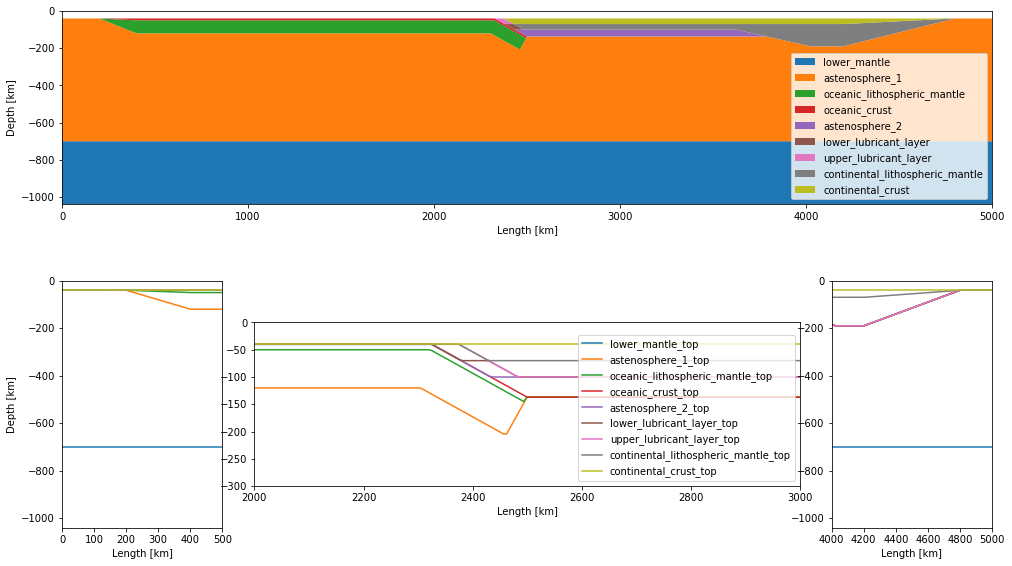

In [22]:
# colors = [
#     [227/255., 52/255., 47/255.],
#     [246/255., 153/255., 63/255.],
#     [255/255., 237/255., 74/255.],
#     [56/255., 193/255., 114/255.],
#     [246/255., 153/255., 63/255.],
#     [77/255., 192/255., 181/255.],
#     [52/255., 144/255., 220/255.],
#     [101/255., 116/255., 205/255.],
#     [149/255., 97/255., 226/255.],
#     [246/255., 109/255., 155/255.]]

dx = 750
fig, ax = plt.subplots(figsize=(25/1.5,15/1.5))
# fig, ax = plt.subplots(figsize=(25,15))

plt.subplot(2, 1, 1, aspect=1.)
aux = 0
for name, interface in interfaces.items():
    interface_new = interfaces[name]/1.0e3
    # plt.plot(interfaces.x/1.0e3, interfaces[name]/1.0e3, label=name, color=colors[aux])
    if (aux>0):
        plt.fill_between(interfaces.x/1.0e3, interface_old, interface_new, label=name[:-4])
    if (aux==0):
        plt.fill_between(interfaces.x/1.0e3, interface_new, z_min/1.0e3, label=name[:-4])
    plt.xlim((x_min/1.0e3, x_max/1.0e3))
    plt.ylim((z_min/1.0e3, z_max/1.0e3))
    plt.xlabel("Length [km]")
    plt.ylabel("Depth [km]")
    name_a = name
    interface_old = interfaces[name]/1.0e3
    plt.legend(loc=4)
    aux += 1
    
plt.subplot(2, 5, 6)
for name, interface in interfaces.items():
    x0lim = x_min / 1.0e3
    x1lim = 500.0
    plt.plot(interfaces.x/1.0e3, interfaces[name]/1.0e3, label=name)
    plt.xlim(x0lim, x1lim)
    plt.ylim((z_min/1.0e3, z_max/1.0e3))
    plt.xlabel("Length [km]")
    plt.ylabel("Depth [km]")

plt.subplot(2, 5, (7, 9), aspect=1)
for name, interface in interfaces.items():
    x0lim = (x_max - x_min) / 2.0 / 1.0e3 - 500.0
    x1lim = (x_max - x_min) / 2.0 / 1.0e3 + 500.0
    plt.plot(interfaces.x/1.0e3, interfaces[name]/1.0e3, label=name)
    plt.xlim(x0lim, x1lim)
    plt.ylim((z_min/1.0e3, z_max/1.0e3))
    plt.ylim((-300, z_max/1.0e3))
    plt.xlabel("Length [km]")
    # plt.ylabel("Depth [km]")
plt.legend(loc=4)    
    
plt.subplot(2, 5, 10)
for name, interface in interfaces.items():
    x0lim = 4000.0
    x1lim = x_max / 1.0e3
    plt.plot(interfaces.x/1.0e3, interfaces[name]/1.0e3, label=name)
    plt.xlim(x0lim, x1lim)    
    plt.ylim((z_min/1.0e3, z_max/1.0e3))
    plt.xlabel("Length [km]")
    # plt.ylabel("Depth [km]")


plt.savefig('out/initial-geometry.pdf')
plt.show()

**Save the interface**

In [23]:
cf = []
de = []
rh = []
pf = []
pe = []
ae = []
av = []

unit_keys = list(units.keys())

for i in range(len(units)):
    cf.append(units[unit_keys[i]].compositional_factor)
    de.append(units[unit_keys[i]].density)
    rh.append(units[unit_keys[i]].radiogenic_heat)
    pf.append(units[unit_keys[i]].pre_exponential_scale_factor)
    pe.append(units[unit_keys[i]].power_law_exponent)
    ae.append(units[unit_keys[i]].activation_energy)
    av.append(units[unit_keys[i]].activation_volume)

units_data = {
    "compositional_factor": cf,
    "density": de,
    "radiogenic_heat": rh,
    "pre-exponential_scale_factor": pf,
    "power_law_exponent": pe,
    "activation_energy": ae,
    "activation_volume": av,
}

# Save interfaces file
save_interfaces(interfaces, units_data, run_dir)

## Initial temperature model

Create a temperature dataset filled with `zeros`

In [24]:
temperature = make_grid(coordinates, value=0)

Trace LAB depth without the subducted portion, which will be included later on.

In [25]:
lid_vertices = [
    [x_min, z_ocean_lab],
    [x_min + edge_clearance, z_ocean_lab],
    [x_min + edge_clearance + oceanic_thin_length, oceanic_lab_depth],
    [subducting_slab_top_x_min, oceanic_lab_depth],
    [subducting_slab_top_x_max, continental_arc_depth],
    [transition_x_min, continental_arc_depth],
    [transition_x_max, continental_lab_depth],
    [x_max - craton_thin_length, continental_lab_depth],
    [x_max - edge_clearance, z_continent_lab],
    [x_max, z_continent_lab]
]

lid = make_interface(
    coordinates,
    lid_vertices
)

if (plate_model):
    beg = np.where(lid["x"].values >= edge_clearance)[0][0]
    end = beg + np.size(plate_x)
    lid.values[beg:end] = -aL[:(end-beg)]

lid += h_air

Temperature is constant and `null` for the air layer
$$ T(z>h_{air}) = 0.0 $$
where $h_{air}$ is the thickness of the air layer.

Temperature increases linearly with depth for the lithosphere
$$ T(h_{air}\geq z\geq h_{litho}(x)) = T_{LAB} \frac{(h_{air}-z)}{h_{litho}(x)-h_{air}} $$
where $h_{litho}(x)$ is the thickness of the lithosphere, $T_{LAB}=1300^{\circ}$C is the temperature at the base of the lithosphere, and $z$ is the depth in meters.

In the asthenosphere ando lower mantle, the temperature is the adiabatic temperature
$$ T(z<h_{litho}(x))={T_0}{\exp{\frac{\alpha g (h_{air} - z)}{C_p}}} $$
where $T_0$ is the potential temperature of the mantle on the surface, $\alpha$ is the thermal expansion coefficient, $g$ is the gravity acceleration, and $C_p$ is the heat capacity.

In [26]:
# Functions to calculate the temperature field
constant = 0.0
q = abs(lid - h_air)
q[q==0] = 1.0E-100
linear = temp_LAB * (h_air - temperature.z) / q
# adiabatic = temp_0 * np.exp(alpha * g * (temperature.z) / heat_capacity)
adiabatic = temp_0 * np.exp(alpha * g * (h_air - temperature.z) / heat_capacity)

In [27]:
# # Transpose the temperature to fix the dimension
temperature = make_grid(coordinates, value=0)
temperature = temperature.transpose("x", "z") 

# Set the lithosphere temperature to 'linear' and both the astenosphere and lower mantle temperatures to 'adiabatic'
linear_or_adiabatic = xr.where(
    temperature.z >= lid,
    linear,
    adiabatic
)

# Set the air layer temperature to `constant`
temperature = xr.where(
    temperature.z >= 0.0,
    constant,
    linear_or_adiabatic
)

# Set the maximum temperature profile to 'adiabatic'
temperature = xr.where(
    temperature > adiabatic,
    adiabatic, 
    temperature
)

# Replaces the upper extremes values from nan to 0. 
temperature = xr.where(
    (temperature.x==x_max) & (temperature.z==z_max),
    0, 
    temperature
) 
temperature = xr.where(
    (temperature.x==x_min) & (temperature.z==z_max),
    0, 
    temperature
) 
# Change -0.0 values to 0.0
temperature = xr.where(
    temperature==-0,
    0.0, 
    temperature
) 
temperature = xr.where(
    temperature<0.0,
    0.0,
    temperature
)

if (plate_model):
    # thinnig portion temperature
    condx = (temperature.x>=corrected_x[0]) & (temperature.x<=corrected_x[-1])
    condz = (temperature.z>=corrected_z[0]) & (temperature.z<=corrected_z[-1])
    temperature[condx, condz] = plate_T

    # oceanic lithosphere
    condx = (temperature.x>=corrected_x[-1]) & (temperature.x<=subducting_slab_top_x_min)
    condz = (temperature.z>=corrected_z[0]) & (temperature.z<=corrected_z[-1])
    temperature[condx, condz] = plate_T[-1,:]

**Calculate the temperature for the subducting portion**

In [28]:
# define a Polygon.polygon where the subducting portion is contained
x0, x1, x2, x3 = subducting_slab_top_x_min, subducting_slab_bot_x_min, subducting_slab_bot_x_max, subducting_slab_top_x_max
y0, y1, y2, y3 = z_max + h_air, oceanic_lab_depth + h_air, subducting_slab_bot_z_min + h_air, subducting_slab_top_z_min + h_air
polygon = Polygon([(x0, y0), (x1, y1), (x2, y2), (x3, y3)])

# calculate a z = a * x + b function for the subducting top surface
xp = np.array([x0, x3])
yp = np.array([y0, y3])
A = np.vstack([xp, np.ones(len(xp))]).T
a, b = np.linalg.lstsq(A, yp, rcond=None)[0]

# check if Point.point is within the Polygon.polygon and calculate its temperature
cond_x = (temperature.x >= np.min(polygon.exterior.coords.xy[0])) & (temperature.x <= np.max(polygon.exterior.coords.xy[0]))
cond_z = (temperature.z >= np.min(polygon.exterior.coords.xy[1])) & (temperature.z <= np.max(polygon.exterior.coords.xy[1]))
for i in temperature.x.where(cond_x, drop=True):
    for j in temperature.z.where(cond_z, drop=True):
        point = Point(i, j)
        if polygon.contains(point):
            aux_dz = abs((a * point.x + b) - point.y)
            real_dz = aux_dz * np.sin(0.5 * np.pi - subducting_slab_slope_rad)
            if (plate_model):
                temperature.data[temperature.x==point.x, temperature.z==point.y] = plate_model_temperature(temp_air, 
                                                                                                           temp_LAB, 
                                                                                                           np.array([corrected_x[-1]]), # any x-position where the steady state is reached
                                                                                                           np.array([real_dz]), # z-position as if the slab was horizontal at the surface
                                                                                                           np.array([abs(oceanic_lab_depth)]), # steady state LAB depth
                                                                                                           u, 
                                                                                                           N, 
                                                                                                           kappa)
            else:
                temperature.data[temperature.x==point.x, temperature.z==point.y] = real_dz * temp_LAB / abs(oceanic_lab_depth)
    
if (diffuse_temperature):
    dx = float(temperature["x"][1] - temperature["x"][0])
    dz = float(temperature["z"][1] - temperature["z"][0])
    cond_air = (np.array(coordinates["z"]) >= h_air)
    temperature.values = diffuse_field(temperature.values, cond_air, kappa, dx, dz, t_max=500_000, fac=100)

**Plot the temperature**

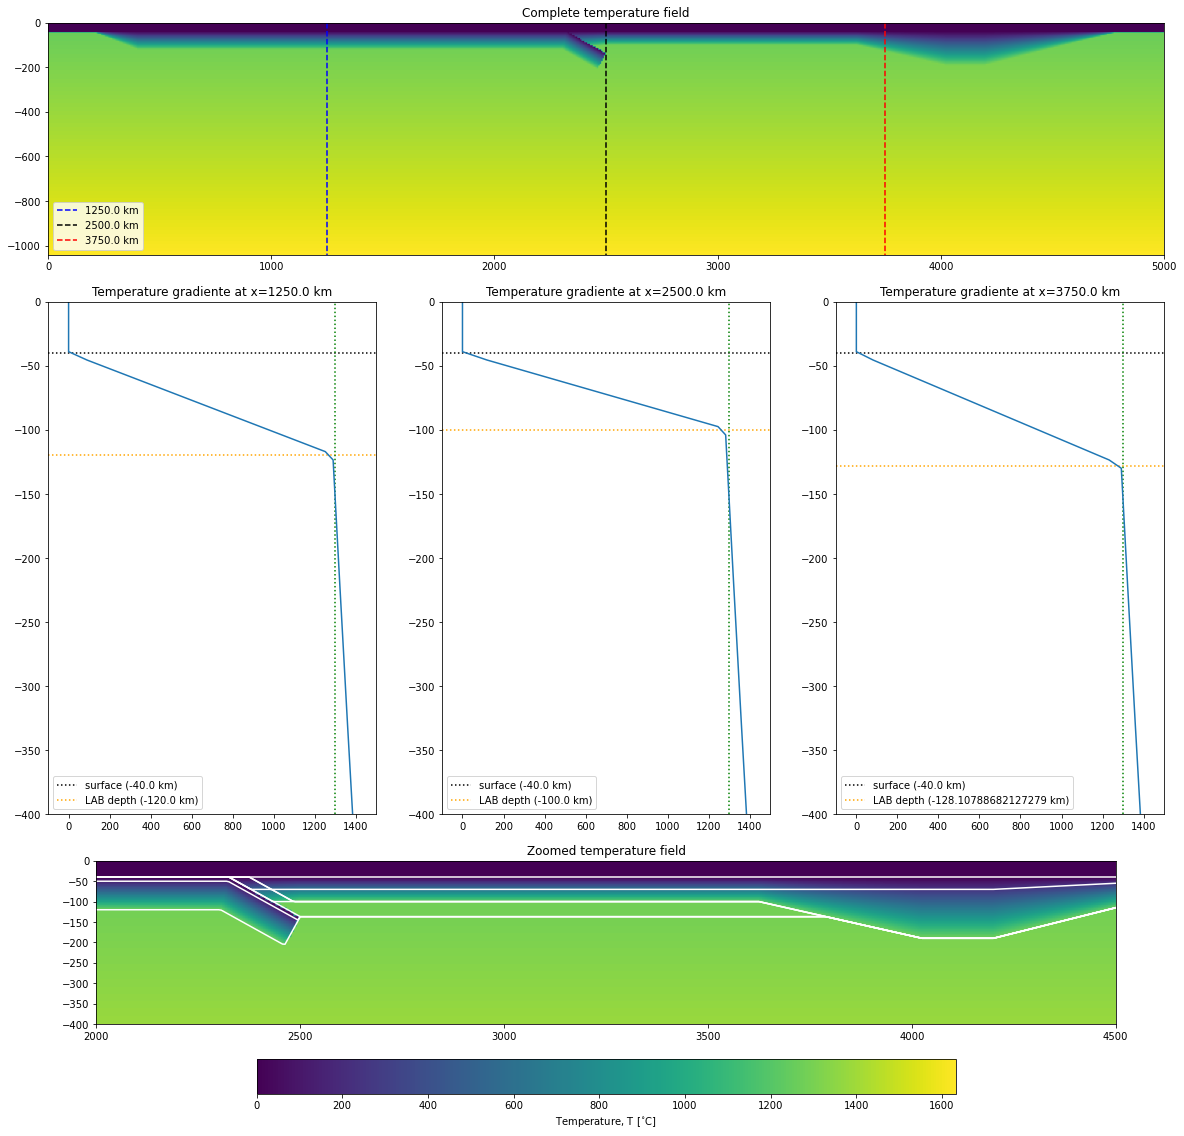

In [29]:
x_perc_1 = 0.25
x_perc_2 = 0.50
x_perc_3 = 0.75
z_lim = -400
T_min_lim, T_max_lim = -100, 1500.0

extent = [x_min/1.0e3, x_max/1.0e3, z_min/1.0e3, z_max/1.0e3]

plt.figure(figsize=(20,30))

# complete teperature
plt.subplot(6, 3, (1, 3))
plt.title("Complete temperature field")
x, y = np.meshgrid(temperature.coords["x"], temperature.coords["z"])
# plt.imshow(temperature.T[:,::-1].T, extent=extent, aspect='equal')
plt.imshow(temperature.T[::-1,:], extent=extent, aspect='equal')
plt.vlines(x_perc_1 * x_max/1.0e3, z_max/1.0e3, z_min/1.0e3, linestyle="dashed", color="blue", label=str(x_perc_1*x_max/1.0e3)+" km")
plt.vlines(x_perc_2 * x_max/1.0e3, z_max/1.0e3, z_min/1.0e3, linestyle="dashed", color="black", label=str(x_perc_2*x_max/1.0e3)+" km")
plt.vlines(x_perc_3 * x_max/1.0e3, z_max/1.0e3, z_min/1.0e3, linestyle="dashed", color="red", label=str(x_perc_3*x_max/1.0e3)+" km")
plt.legend(loc=3)

# temperature gradient at (x_perc_1 * x_max)
plt.subplot(6, 3, (4, 7))
plt.title(f"Temperature gradiente at x={x_perc_1*x_max/1.0e3} km")
y, x = temperature["z"]/1.0e3, temperature.sel(x=x_perc_1 * x_max, method="nearest")
if (h_air < 0): plt.hlines(h_air/1.0e3, T_min_lim, T_max_lim, label="surface ({} km)".format(h_air/1.0e3), color="black", linestyle="dotted")
z_lid = lid.sel(x=x_perc_1 * x_max, method="nearest")/1.0e3
plt.hlines(z_lid, T_min_lim, T_max_lim, color="orange", linestyle="dotted", label="LAB depth ({} km)".format(z_lid.values))
plt.vlines(1300, z_lim, extent[3], linestyles='dotted', color='green')
plt.ylim(z_lim, extent[3])
plt.plot(x, y)
plt.xlim(T_min_lim, T_max_lim)
plt.legend(loc=3)

# temperature gradient at (x_perc_2 * x_max)
plt.subplot(6, 3, (5, 8))
plt.title(f"Temperature gradiente at x={x_perc_2*x_max/1.0e3} km")
y, x = temperature["z"]/1.0e3, temperature.sel(x=x_perc_2 * x_max, method="nearest")
if (h_air < 0): plt.hlines(h_air/1.0e3, T_min_lim, T_max_lim, label="surface ({} km)".format(h_air/1.0e3), color="black", linestyle="dotted")
z_lid = lid.sel(x=x_perc_2 * x_max, method="nearest")/1.0e3
plt.hlines(z_lid, T_min_lim, T_max_lim, color="orange", linestyle="dotted", label="LAB depth ({} km)".format(z_lid.values))
z_lid = lid.sel(x=x_perc_2 * x_max, method="nearest").values
plt.vlines(1300, z_lim, extent[3], linestyles='dotted', color='green')
plt.ylim(z_lim, extent[3])
plt.plot(x, y)
plt.xlim(T_min_lim, T_max_lim)
plt.legend(loc=3)

# temperature gradient at (x_perc_3 * x_max)
plt.subplot(6, 3, (6, 9))
plt.title(f"Temperature gradiente at x={x_perc_3*x_max/1.0e3} km")
y, x = temperature["z"]/1.0e3, temperature.sel(x=x_perc_3 * x_max, method="nearest")
if (h_air < 0): plt.hlines(h_air/1.0e3, T_min_lim, T_max_lim, label="surface ({} km)".format(h_air/1.0e3), color="black", linestyle="dotted")
z_lid = lid.sel(x=x_perc_3 * x_max, method="nearest")/1.0e3
plt.hlines(z_lid, T_min_lim, T_max_lim, color="orange", linestyle="dotted", label="LAB depth ({} km)".format(z_lid.values))
z_lid = lid.sel(x=x_perc_3 * x_max, method="nearest").values
plt.vlines(1300, z_lim, extent[3], linestyles='dotted', color='green')
plt.ylim(z_lim, extent[3])
plt.plot(x, y)
plt.xlim(T_min_lim, T_max_lim)
plt.legend(loc=3)

# zoomed teperature
plt.subplot(6, 3, (10, 12))
plt.title("Zoomed temperature field")
x, y = np.meshgrid(temperature.coords["x"], temperature.coords["z"])
# plt.imshow(temperature.T[:,::-1].T, extent=extent, aspect='equal')
plt.imshow(temperature.T[::-1,:], extent=extent, aspect='equal')
for name, interface in interfaces.items():
    plt.plot(interface["x"]/1.0e3, interface.values/1.0e3, color="white", linewidth=1.5)
plt.xlim(2000, 4500)
plt.ylim(z_lim, extent[3])
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'Temperature, T [$^{\circ}$C]')

**Save initial temperature distribution**

In [30]:
save_temperature(temperature, run_dir)

## Initial velocity model

$$ u_{x}(x=x_{min},z) =
  \begin{cases}
    0      & \quad \text{if } z > h_{air}\\
    u_{0}  & \quad \text{if } h_{air} \geq z \geq h_{litho}\\
    v(z)   & \quad \text{if } h_{litho} > z \geq h_{asthe}\\
    0      & \quad \text{if } z < h_{asthe}
  \end{cases}
$$

$$ u_{x}(x=x_{max},z) =
  \begin{cases}
    0      & \quad \text{if } z > h_{air}\\
    0  & \quad \text{if } h_{air} \geq z \geq h_{litho}\\
    w(z)   & \quad \text{if } h_{litho} > z \geq h_{asthe}\\
    0      & \quad \text{if } z < h_{asthe}
  \end{cases}
$$

$$ u_{z}(x,z)=0 $$

where $u_x$ and $u_z$ are the velocities in the $x$ and $z$ directions, $u_{0}$ is a constant velocity, $h_{asthe}$ is the depth of the asthenosphere, $v(z)$ and $w(z)$ are functions.

In [31]:
vx = make_grid(coordinates, value=0)
vz = make_grid(coordinates, value=0)
print(f'Velocity clearance layer is {clearance/1.0E3} km thick')

################################################################################
# velocity profile at x = x_min (left side)
################################################################################
# air
cond = (vx[0,:].z > (h_air + clearance))
vx[0,cond] = 0

# air clearance zone
zp = [h_air, (h_air + clearance)]
fp = [u0, 0]
cond = (vx[0,:].z <= (h_air + clearance)) & (vx[0,:].z >= h_air)
vx[0,cond] = np.interp(vx[0, cond].z, zp, fp)

# oceanic lithosphere
cond = (vx[0,:].z <= h_air) & (vx[0,:].z >= float(lid[0]))
vx[0,cond] = u0

# mantle clearance zone
cond = (vx[0,:].z <= float(lid[0])) & (vx[0,:].z >= float(lid[0] - clearance))
vx[0,cond] = u0

# lower mantle
cond = (vx[0,:].z < astenosphere_depth + h_air)
vx[0,cond] = 0

# mantle zone
zp = [astenosphere_depth + h_air, float(lid[0] - clearance)]
fp = [0, u0]
cond = (vx[0,:].z < float(lid[0] - clearance)) & (vx[0,:].z >= astenosphere_depth + h_air)
vx[0,cond] = np.interp(vx[0, cond].z, zp, fp)

# area below the curve
a0 = np.trapz(vx[0,:], vx[0,:].z)

################################################################################
# velocity profile at x = x_max (right side)
################################################################################
# air
cond = (vx[-1,:].z > h_air)
vx[-1,cond] = 0

# air clearance zone
zp = [-clearance, 0] 
fp = [0, u0]
cond = (vx[-1,:].z <= 0) & (vx[-1,:].z >= -clearance)
vx[-1,cond] = np.interp(vx[0, cond].z, zp, fp)

# continental lithosphere
cond = (vx[-1,:].z <= h_air) & (vx[-1,:].z >= lid[-1])
vx[-1,cond] = 0

# mantle clearance zone
cond = (vx[-1,:].z <= float(lid[-1])) & (vx[-1,:].z >= float(lid[-1] - clearance))
vx[-1,cond] = 0

# lower mantle
cond = (vx[-1,:].z < astenosphere_depth + h_air)
vx[-1,cond] = 0

# mantle zone
cond = (vx[-1,:].z < float(lid[-1] - clearance)) & (vx[-1,:].z >= astenosphere_depth + h_air)
w0 = u0
z0 = float(lid[-1] - clearance)
z1 = astenosphere_depth + h_air

w_aux = np.linspace(0, 1_000, 101) # check the difference for all the velocities 0 <= u <= 1_000 [mm/yr]
d_aux = np.zeros(np.size(w_aux))
for i in range(np.size(w_aux)):    
    # calculate a curve f(z) = a*z + b to the desired depths
    a = w_aux[i] * mm_per_year / (z1 - z0)
    b = - a * z0
    vx[-1,cond] = a * vx[-1, cond].z + b
    
    # checks the area difference and stores it inot d_aux
    a_aux = np.trapz(vx[-1,:], vx[-1,:].z)
    d_aux[i] = a0 - a_aux

w = interpolate.interp1d(d_aux, w_aux)

# uses the best curve f(z) = a*z + b to make the area difference the smallest
w0 = w(0) * mm_per_year
a = w0 / (z1 - z0)
b = - a * z0
vx[-1,cond] = a * vx[-1, cond].z + b
a1 = np.trapz(vx[-1,:], vx[-1,:].z)

print(f'Maximum velocity on the right side is {w0/mm_per_year} [mm/yr]')
print(f'Area difference between the two curves is {a0-a1} (left-right)')

# save velocity file
if (velocity_borders):
    fname = f"{run_dir}/input_velocity_0.txt"
    file = open(fname, 'w')
    file.write("v1\nv2\nv3\nv4\n")
    for j in range(shape[1]):
        for i in range(shape[0]):
            file.write(str(float(vx.values[i,j]))+"\n")
            file.write(str(float(vz.values[i,j]))+"\n")
    file.close()

if (velocity_borders):
    plt.figure(figsize=(5,10))
    
x0lim = -1
x1lim = np.ceil(w0/mm_per_year)

if (velocity_borders) and (clearance > 0.0):
    plt.axhspan((h_air+clearance)/1.0E3, h_air/1.0E3, x0lim, x1lim, color='#E0BBE4', alpha=0.6, label='Oceanic surface clearance')
    plt.axhspan((oceanic_lab_depth+h_air)/1.0E3, (oceanic_lab_depth+h_air-clearance)/1.0E3, x0lim, x1lim, color='#B7EAF7', alpha=0.6, label='Oceanic LAB clearance')
    plt.axhspan((-clearance)/1.0E3, 0.0, x0lim, x1lim, color='#FFEDDA', alpha=0.6, label='Continental surface clearance')
    plt.axhspan((continental_lab_depth+h_air)/1.0E3, (continental_lab_depth+h_air-clearance)/1.0E3, x0lim, x1lim, color='#B5EAD7', alpha=0.6, label='Continental LAB clearance')

if (velocity_borders):
    plt.plot(vx[0,:]/mm_per_year,vx[0,:].z/1.0e3, label=r"$x_{left}$")
    plt.plot(vx[-1,:]/mm_per_year,vx[-1,:].z/1.0e3, label=r"$x_{right}$")

    plt.ylabel("Depth [km]")
    plt.xlabel("Velocity [mm/yr]")
    plt.ylim(z_min/1.0e3, z_max/1.0e3)
    plt.xlim(x0lim, x1lim)
    plt.legend(loc=4)

Velocity clearance layer is 15.0 km thick
Maximum velocity on the right side is 52.482119329945434 [mm/yr]
Area difference between the two curves is 0.0 (left-right)


## Create the parameter file

In [32]:
free_surface = 'False'
adiabatic_component = 'on'
radiogenic_component = 'on'
viscosity_min = 3.5e19
if (h_air != 0):
    free_surface = 'True'
    viscosity_min = viscosity_min / 10.0
    
velocity_from_ascii = 'False'    
if (velocity_borders):
    velocity_from_ascii = 'True'
    
params = f"""# Geometry
nx                                  = {shape[0]}
nz                                  = {shape[1]}
lx                                  = {x_max}
lz                                  = {-z_min}

# Simulation options
solver                              = direct
denok                               = 1.0e-10
rtol                                = 1.0e-7
RK4                                 = Euler
Xi_min                              = 1.0e-7
random_initial_strain               = 0.0
pressure_const                      = -1.0
initial_dynamic_range               = True
periodic_boundary                   = False
high_kappa_in_asthenosphere         = False
basal_heat                          = -1.0

# Particles options
particles_per_element               = {particles_per_element}
particles_per_element_x             = 0
particles_per_element_z             = 0
particles_perturb_factor            = 0.7

# Surface processes
sp_surface_tracking                 = {free_surface}
sea_level                           = 0.0
sp_surface_processes                = False
sp_dt                               = 0
a2l                                 = True
sp_mode                             = 1
free_surface_stab                   = True
theta_FSSA                          = 0.5
sticky_blanket_air                  = False
precipitation_profile_from_ascii    = False
climate_change_from_ascii           = False

# Time constrains
step_max                            = 7000
time_max                            = 10.0e6
dt_max                              = 10.0e3
step_print                          = 10
sub_division_time_step              = 1.0
initial_print_step                  = 0
initial_print_max_time              = 1.0e6

# Viscosity
viscosity_reference                 = 3.5e20
viscosity_max                       = 7.0e23
viscosity_min                       = {viscosity_min}
viscosity_per_element               = constant
viscosity_mean_method               = arithmetic
viscosity_dependence                = pressure

# External ASCII inputs/outputs
interfaces_from_ascii               = True
n_interfaces                        = {n_interfaces}
temperature_from_ascii              = True
velocity_from_ascii                 = {velocity_from_ascii}
variable_bcv                        = False
multi_velocity                      = False
binary_output                       = False
print_step_files                    = True

# Physical parameters
temperature_difference              = {temperature.values.max() - temperature.values.min()}
thermal_expansion_coefficient       = {alpha}
thermal_diffusivity_coefficient     = {kappa}
gravity_acceleration                = {g}
density_mantle                      = 3300.
heat_capacity                       = {heat_capacity}
non_linear_method                   = on
adiabatic_component                 = {adiabatic_component}
radiogenic_component                = {radiogenic_component}

# Velocity boundary conditions
top_normal_velocity                 = fixed
top_tangential_velocity             = free
bot_normal_velocity                 = fixed
bot_tangential_velocity             = free
left_normal_velocity                = fixed
left_tangential_velocity            = free
right_normal_velocity               = fixed 
right_tangential_velocity           = free

# Temperature boundary conditions
top_temperature                     = fixed
bot_temperature                     = fixed
left_temperature                    = fixed
right_temperature                   = free
rheology_model                      = 19
T_initial                           = 0
"""

# Create the parameter file
with open(os.path.join(run_dir,"param.txt"), "w") as f:
    for line in params.split("\n"):
        f.write(line + "\n")